In [1]:
from fastai.vision.all import *

In [2]:
path = Path("./")
path.ls()

(#17) [Path('G2Net GravWave Sub1 61RocAuc.ipynb'),Path('subset'),Path('Submissions'),Path('test'),Path('.ipynb_checkpoints'),Path('traincqt'),Path('G2Net CQT Working .5ROC.ipynb'),Path('sample_submission.csv'),Path('g2net-gravitational-wave-detection.zip'),Path('G2Net GravWave Sub7 84RocAuc-Copy1.ipynb')...]

In [3]:
Path.BASE_PATH = path

In [4]:
files = get_image_files(path/'traincqt')
len(files)

560000

In [5]:
files[0]

Path('traincqt/3f80cf46b2.png')

In [6]:
labels = pd.read_csv(path/'training_labels.csv')
labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [7]:
labels['id'] = labels['id'].map(lambda x : f'{path}/traincqt/{x}.png' )
labels.head()

,id,target
0,./traincqt/00000e74ad.png,1
1,./traincqt/00001f4945.png,0
2,./traincqt/0000661522.png,0
3,./traincqt/00007a006a.png,0
4,./traincqt/0000a38978.png,1


In [8]:
def getx(df):
    return df['id']

def gety(df):
    return df['target']

In [9]:
def custom_splitter(train_pct):
    def fn(name_list):
        train_idx, valid_idx = RandomSplitter(valid_pct=0.3, seed=42)(name_list)
        np.random.shuffle(train_idx)
        train_len = int(len(train_idx) * train_pct)
        np.random.shuffle(valid_idx)
        valid_len = int(len(valid_idx) * train_pct)
        return train_idx[0:train_len], valid_idx[0:valid_len]
    return fn

In [10]:
def build_data(df, bs=32, train_pct=.05):
    grav = DataBlock(blocks = (ImageBlock,CategoryBlock),
                 get_x  = getx,
                 get_y  = gety,
                 splitter = custom_splitter(train_pct),
                 #item_tfms = Resize(460),
                 batch_tfms = [*aug_transforms(do_flip=False, max_rotate=0),
                               Normalize.from_stats(*imagenet_stats)]) #, 
                #splitter=RandomSplitter(valid_pct=0.3, seed=42))
    grav.summary(df)
    return grav.dataloaders(df, bs=bs)

In [11]:
dls = build_data(labels, train_pct=1)

Setting-up type transforms pipelines
0       ./traincqt/00000e74ad.png       1
1       ./traincqt/00001f4945.png       0
2       ./traincqt/0000661522.png       0
3       ./traincqt/00007a006a.png       0
4       ./traincqt/0000a38978.png       1
...                           ...     ...
559995  ./traincqt/ffff9a5645.png       1
559996  ./traincqt/ffffab0c27.png       0
559997  ./traincqt/ffffcf161a.png       1
559998  ./traincqt/ffffd2c403.png       0
559999  ./traincqt/fffff2180b.png       0

[560000 rows x 2 columns]
Found 560000 items
2 datasets of sizes 392000,168000
Setting up Pipeline: getx -> PILBase.create
Setting up Pipeline: gety -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: getx -> PILBase.create
    starting from
      id        ./traincqt/941604b92d.png
target                            1
Name: 323404, dtype: object
    applying getx gives
      ./traincqt/941604b92d.png
    applying PILBase.create gives
      PILImage mo

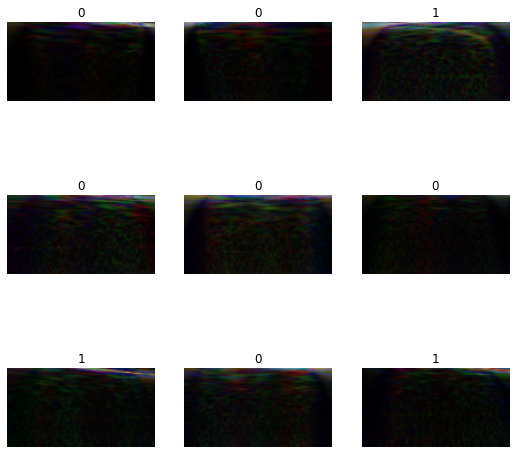

In [12]:
dls.show_batch()

In [14]:
learn = cnn_learner(dls, resnet34, metrics=RocAucBinary(), cbs=[SaveModelCallback(with_opt=True)])

SuggestedLRs(valley=6.30957365501672e-05)

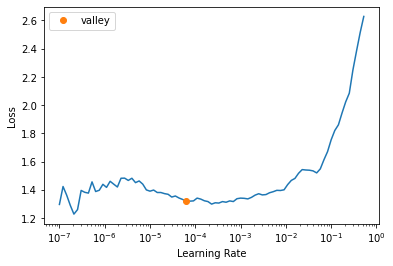

In [15]:
learn.lr_find()

In [16]:
learn.fine_tune(4, base_lr=6e-5)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.716214,0.667262,0.618776,1:41:57


Better model found at epoch 0 with valid_loss value: 0.6672622561454773.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.588844,0.570901,0.742067,1:27:00
1,0.557756,0.534978,0.785570,1:32:01
2,0.554955,0.533011,0.794969,1:28:06
3,0.545752,0.524111,0.796611,1:43:19


Better model found at epoch 0 with valid_loss value: 0.5709007978439331.
Better model found at epoch 1 with valid_loss value: 0.5349780321121216.
Better model found at epoch 2 with valid_loss value: 0.5330114364624023.
Better model found at epoch 3 with valid_loss value: 0.5241113305091858.


In [17]:
save_model(path/'models/modelwithaug', learn, learn.opt)

In [20]:
test = learn.load(path/'model')

/home/quantumabyss/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [27]:
other = load_model(path/'models/tester', learn, learn.opt)

SuggestedLRs(valley=6.30957365501672e-05)

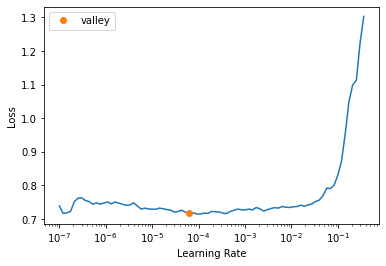

In [34]:
learn.lr_find()

In [35]:
learn.fine_tune(2, base_lr=6e-5)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.714547,0.647186,0.650449,00:22


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.703839,0.647388,0.653478,00:26
1,0.701694,0.645486,0.654673,00:26


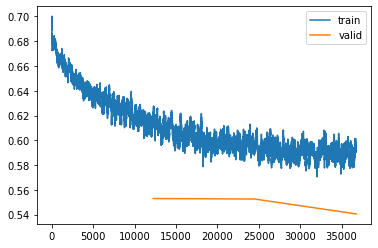

In [85]:
learn.recorder.plot_loss()

In [18]:
sample = pd.read_csv(path/'sample_submission.csv')
sample

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5
...,...,...
225995,ffff4125f1,0.5
225996,ffff9d32a6,0.5
225997,ffff9f4c1f,0.5
225998,ffffa19693,0.5


In [19]:
sampledf = sample.copy()
sampledf['id'] = sampledf['id'].map(lambda x: f'{path}/testcqt/{x}.png')
sampledf

,id,target
0,./testcqt/00005bced6.png,0.5
1,./testcqt/0000806717.png,0.5
2,./testcqt/0000ef4fe1.png,0.5
3,./testcqt/00020de251.png,0.5
4,./testcqt/00024887b5.png,0.5
...,...,...
225995,./testcqt/ffff4125f1.png,0.5
225996,./testcqt/ffff9d32a6.png,0.5
225997,./testcqt/ffff9f4c1f.png,0.5
225998,./testcqt/ffffa19693.png,0.5


In [20]:
test_dl = dls.test_dl(sampledf)

In [21]:
preds, _ = learn.get_preds(dl=test_dl)

In [22]:
sample.target = np.array(preds[:,1])
sample.to_csv('submission8.csv', index=False)
sample.head()

,id,target
0,00005bced6,0.988992
1,0000806717,0.484959
2,0000ef4fe1,0.250859
3,00020de251,0.514944
4,00024887b5,0.252407


In [131]:
preds

tensor([[0.0070, 0.9930],
        [0.4347, 0.5653],
        [0.6024, 0.3976],
        ...,
        [0.7632, 0.2368],
        [0.0044, 0.9956],
        [0.8188, 0.1812]])

In [420]:
valid_predicts, _ = learn.get_preds()

In [ ]:
valid_probs = np.array(valid_predicts[:,1])
valid_targets = train_df.loc[valid_idx].target.values
valid_score = roc_auc_score(valid_targets, valid_probs)